In [1]:
%load_ext tensorboard
import os, sys
import datetime
import copy
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import torch
from torch.utils.data import Dataset
from torch.utils.data import random_split, DataLoader
from torch import nn, optim

from pytorch_lightning import LightningModule
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint, ProgressBar
from tqdm import tqdm
from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix, roc_auc_score
dvc = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {dvc} device")

/afs/cern.ch/work/c/cchan/hmumuTorch/env/lib64/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using cuda device


In [2]:
# Data sets for training W0 and training W1

class w0_dataset(Dataset):
    def __init__(self, T, R):
        super(w0_dataset, self).__init__()
        
        self.T = T
        self.R = R
        
    def __len__(self):
        return len(self.T)

    def __getitem__(self, idx):
        return self.T[idx], self.R[idx]
    
class w1_dataset(Dataset):
    def __init__(self, T0, R0, theta0, T1, R1, theta1):
        super(w1_dataset, self).__init__()
        
        self.T = np.concatenate([T0, T1])
        self.R = np.concatenate([R0, R1])
        self.theta = np.concatenate([theta0, theta1])
        self.label = np.concatenate([np.zeros((len(T0), 1)), np.ones((len(T1), 1))])
                
    def __len__(self):
        return len(self.T)

    def __getitem__(self, idx):
        return self.T[idx], self.R[idx], self.theta[idx], self.label[idx]

In [3]:
# Loss function (NLL)

class NLLLoss(nn.Module):

    def __init__(self, obs_data, bins, normalize=False, device="cpu"):
        super(NLLLoss, self).__init__()
        self.normalize = normalize
        self.dvc = device
        self.obs_data = torch.from_numpy(obs_data).float().to(self.dvc)
        self.bins = torch.from_numpy(bins).float().to(self.dvc)
#         if type(obs_data) == torch.Tensor:
#             self.obs_data = obs_data.float().to(self.dvc)
#         elif type(obs_data) == np.ndarray:
#             self.obs_data = torch.from_numpy(obs_data).float().to(self.dvc)
#         elif type(obs_data) == list:
#             self.obs_data = torch.tensor(obs_data).float().to(self.dvc)
#         if type(bins) == torch.Tensor:
#             self.bins = bins.float().to(self.dvc)
#         elif type(bins) == np.ndarray:
#             self.bins = torch.from_numpy(bins).float().to(self.dvc)
#         elif type(bins) == list:
#             self.bins = torch.tensor(bins).float().to(self.dvc)
        self.h_obs_data = torch.tensor([(torch.bucketize(self.obs_data, self.bins)==i).sum() for i in range(1, len(self.bins))]).to(self.dvc)
        self.y_obs_data = len(self.obs_data)
        
    def forward(self, R, weights, theta):
        h_R = None
        for i in range(1, len(self.bins)):
            h_R_i = torch.mul((torch.bucketize(R, self.bins)==i), weights).sum().reshape(1)
            h_R = torch.cat((h_R, h_R_i)) if h_R != None else h_R_i
        if self.normalize: h_R = h_R * self.y_obs_data / h_R.sum()
        log_gauss = torch.neg(torch.div(torch.pow(theta, 2), 2.))
        nll = torch.neg(torch.add(torch.sub(torch.mul(self.h_obs_data, torch.log(h_R)), h_R).sum(), log_gauss))
        return nll

class NLLLoss_2D(nn.Module):

    def __init__(self, obs_data, bins1, bins2, device="cpu"):
        super(NLLLoss_2D, self).__init__()
        self.dvc = device
        self.h_obs_data = np.array([[((np.digitize(obs_data[:,0], bins1)==i) * (np.digitize(obs_data[:,1], bins2)==j)).sum() for j in range(1, len(bins2))] for i in range(1, len(bins1))])
        self.bins1 = torch.from_numpy(bins1).float().to(self.dvc)
        self.bins2 = torch.from_numpy(bins2).float().to(self.dvc)
#         if type(bins1) == torch.Tensor:
#             self.bins1 = bins.float().to(self.dvc)
#         elif type(bins1) == np.ndarray:
#             self.bins1 = torch.from_numpy(bins1).float().to(self.dvc)
#         elif type(bins1) == list:
#             self.bins1 = torch.tensor(bins1).float().to(self.dvc)
#         if type(bins2) == torch.Tensor:
#             self.bins2 = bins2.float().to(self.dvc)
#         elif type(bins2) == np.ndarray:
#             self.bins2 = torch.from_numpy(bins2).float().to(self.dvc)
#         elif type(bins2) == list:
#             self.bins2 = torch.tensor(bins2).float().to(self.dvc)
        self.y_obs_data = len(obs_data)
        
    def forward(self, R, weights, theta):
        nll = 0
        for i in range(1, len(self.bins1)):
            for j in range(1, len(self.bins2)):
                h_R_ij = torch.matmul(torch.transpose((torch.bucketize(R, self.bins1)==i).double()*weights.reshape(-1,1), 0, 1), (torch.bucketize(R, self.bins2)==j).double())[0,1]#.reshape(1,1)
                if h_R_ij > 0:
                    nll += self.h_obs_data[i-1, j-1]*torch.log(h_R_ij) - h_R_ij
        log_gauss = torch.neg(torch.div(torch.pow(theta, 2), 2.))
        nll = torch.neg(torch.add(nll, log_gauss))
        return nll
    
    
def roc_auc(input, target, weight=None):
    fpr, tpr, _ = roc_curve(target, input, sample_weight=weight)
    tpr, fpr = np.array(list(zip(*sorted(zip(tpr, fpr)))))
    return 1 - auc(tpr, fpr)

In [4]:
# All the networks (W0, W1 and theta)

class w0_network(nn.Module):
    def __init__(self, nodes=[50, 50, 50], sigmoid=False, std_params=None):
        super(w0_network, self).__init__()
            
        self.std_params = std_params
        self.sigmoid = sigmoid
        self.linear_relu_stack = nn.Sequential()
        for i in range(len(nodes)+1):
            self.linear_relu_stack.add_module(f"linear_{i}", nn.Linear(1 if i==0 else nodes[i-1], nodes[i] if i<len(nodes) else 1))
            if i<len(nodes): self.linear_relu_stack.add_module(f"relu_{i}", nn.ReLU())
        if self.sigmoid: self.linear_relu_stack.add_module("sigmoid", nn.Sigmoid())
        
    def forward(self, T):
        if self.std_params: T = (T-self.std_params[0])/self.std_params[1]
        logit = self.linear_relu_stack(T)
        if self.sigmoid:
            return logit / (1 - logit)
        else:
            return torch.exp(logit)
        
class w0_dummy(nn.Module):
    def __init__(self):
        super(w0_dummy, self).__init__()
        
    def forward(self, T):
        return 1
    
class w1RT_network(nn.Module):
    def __init__(self, nodes=[50, 50, 50], sigmoid=True, std_params=None, n_inputs=4, dropouts=[0, 0.1, 0, 0]):
        super(w1RT_network, self).__init__()
        
        self.std_params = std_params
        self.sigmoid = sigmoid
        self.linear_relu_stack = nn.Sequential()
        self.n_inputs = n_inputs
        for i in range(len(nodes)+1):
            self.linear_relu_stack.add_module(f"linear_{i}", nn.Linear(self.n_inputs if i==0 else nodes[i-1], nodes[i] if i<len(nodes) else 1))
            if i<len(nodes):
                self.linear_relu_stack.add_module(f"relu_{i}", nn.ReLU())
                self.linear_relu_stack.add_module(f"batchNorm_{i}", nn.BatchNorm1d(nodes[i]))
            if dropouts[i] > 0: self.linear_relu_stack.add_module(f"dropout_{i}", nn.Dropout(p=dropouts[i]))
        if self.sigmoid: self.linear_relu_stack.add_module("sigmoid", nn.Sigmoid())
        
    def forward(self, T, R, theta):
        T = (T-self.std_params[0])/self.std_params[1]
        R = (R-self.std_params[2])/self.std_params[3]
        x = torch.cat([R, T, theta], dim=1)
        logit = self.linear_relu_stack(x)
        if self.sigmoid:
            return logit / (1 - logit + 0.00000000000001)
        else:
            return torch.exp(logit)

class w1T_network(w1RT_network):
    def __init__(self, n_inputs=2, *args, **kwargs):
        super(w1T_network, self).__init__(n_inputs=n_inputs, *args, **kwargs)
        
    def forward(self, T, R, theta):
        T = (T-self.std_params[0])/self.std_params[1]
        x = torch.cat([T, theta], dim=1)
        logit = self.linear_relu_stack(x)
        if self.sigmoid:
            return logit / (1 - logit + 0.00000000000001)
        else:
            return torch.exp(logit)
        
class w1_dummy(nn.Module):
    def __init__(self):
        super(w1_dummy, self).__init__()
        
    def forward(self, T, R, theta):
        return 1
    
class theta_module(nn.Module):
    def __init__(self, init_value=0.):
        super(theta_module, self).__init__()
        self.theta = nn.Parameter(torch.ones(1) * init_value)
        
    def forward(self):
        return self.theta

In [5]:
# training and testing utilities

class w1_trainer:
    def __init__(self, train_dataloader, val_dataloader, model_w1, loss_fn, optimizer, max_epoch=1000, patience=10):
        self.train_dataloader = train_dataloader
        self.val_dataloader = val_dataloader
        self.model_w1 = model_w1
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.max_epoch = max_epoch
        self.patience = patience
        
        print("===================== Model W1 =====================")
        print(model_w1)

        self.best_state = self.model_w1.state_dict()
        self.best_epoch = None
        self.best_val_loss = None
        self.i_try = 0
        self.epoch = 0
        self.size = len(train_dataloader.dataset)
        
    def backpropagation(self, loss):
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
    def train_step(self):
        self.model_w1.train()
        for batch, (T, R, theta, label) in enumerate(self.train_dataloader):
            T, R, theta, label = T.to(dvc), R.to(dvc), theta.to(dvc), label.to(dvc)

            W = self.model_w1(T, R, theta)
            logit = W/(W + 1)
            loss = self.loss_fn(logit, label.double())

            # Backpropagation
            self.backpropagation(loss)

            loss, current = loss.item(), (batch+1) * len(R)
            print("\r" + f"[Epoch {self.epoch:>3d}] [{current:>5d}/{self.size:>5d}] [Train_loss: {loss:>7f}]", end="")
        
    def eval_step(self, data_loader):
        self.model_w1.eval()
        Ws, logits, labels = None, None, None
        with torch.no_grad():
            for batch, (T, R, theta, label) in enumerate(data_loader):
                T, R, theta, label = T.to(dvc), R.to(dvc), theta.to(dvc), label.to(dvc)

                W = self.model_w1(T, R, theta)
                Ws = torch.cat([Ws, W]) if Ws is not None else W
                labels = torch.cat([labels, label]) if labels is not None else label
            logits = Ws/(Ws + 1)
            loss = self.loss_fn(logits, labels.double())
            auc = roc_auc(logits.cpu().numpy().reshape(-1), labels.cpu().numpy().reshape(-1))
        return loss, auc
    
    def fit(self, n_epoch=None):   
        max_epoch = (self.epoch+n_epoch+1) if n_epoch else self.max_epoch
        
        for epoch in range(self.epoch+1, max_epoch):
            self.epoch = epoch
            
            # train
            self.train_step()

            # evaluate loss for traing set
            train_loss, train_auc = self.eval_step(self.train_dataloader)

            # evaluate loss for validation set
            val_loss, val_auc = self.eval_step(self.val_dataloader)

            print("\r" + " "*(50), end="")
            print("\r" + f"[Epoch {epoch:>3d}] [Train_loss: {train_loss:>7f} Train_auc: {train_auc:>7f}] [Val_loss: {val_loss:>7f} Val_auc: {val_auc:>7f}]")

            if self.best_val_loss == None or val_loss < self.best_val_loss:
                self.best_val_loss = val_loss
                self.best_state = copy.deepcopy(self.model_w1.state_dict())
                self.best_epoch = epoch
                self.i_try = 0
            elif self.i_try < self.patience:
                self.i_try += 1
            else:
                print(f"Early stopping! Restore state at epoch {self.best_epoch}.")
                print(f"[Best_val_loss: {self.best_val_loss:>7f}]")
                self.model_w1.load_state_dict(self.best_state)
                break
                
def test_w1(test_dataloader, model_w1RT, model_w1T, theta):
       
    # now evaluate performance at the epoch end
    model_w1RT.eval()
    model_w1T.eval()

    # evaluate loss for test set
    Ts, Rs, W1s = None, None, None
    with torch.no_grad():
        for batch, (T, R) in enumerate(test_dataloader):
            T, R = T.to(dvc), R.to(dvc)
            ones = torch.ones(len(R), 1).to(dvc)

            # Compute weights
            W1 = model_w1RT(T, R, ones*theta)/model_w1T(T, R, ones*theta)
            Ts = torch.cat([Ts, T]) if Ts is not None else T
            Rs = torch.cat([Rs, R]) if Rs is not None else R
            W1s = torch.cat([W1s, W1]) if W1s is not None else W1
    return Ts, Rs, W1s

class w0_trainer:
    def __init__(self, train_dataloader, val_dataloader, model_w0, model_w1RT, model_w1T, model_theta, loss_fn, optimizer, max_epoch=1000, patience=10):
        self.train_dataloader = train_dataloader
        self.val_dataloader = val_dataloader
        self.model_w0 = model_w0
        self.model_w1RT = model_w1RT
        self.model_w1T = model_w1T
        self.model_theta = model_theta
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.max_epoch = max_epoch
        self.patience = patience
        
        print("===================== Model W0 =====================")
        print(self.model_w0)
        print("===================== Model W1RT =====================")
        print(self.model_w1RT)
        print("===================== Model W1T =====================")
        print(self.model_w1T)
        print(f"Initial theta: {self.model_theta().item()}")

        self.model_w1RT.eval()
        self.model_w1T.eval()
    
        self.best_state = self.model_w0.state_dict()
        self.best_theta = self.model_theta.state_dict()
        self.best_epoch = None
        self.best_val_loss = None
        self.i_try = 0
        self.epoch = 0
        self.size = len(train_dataloader.dataset)
        
    def backpropagation(self, loss):
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
    def train_step(self):
        self.model_w0.train()
        self.model_theta.train()
        for batch, (T, R) in enumerate(self.train_dataloader):
            T, R = T.to(dvc), R.to(dvc)
            ones = torch.ones(len(T), 1).to(dvc)

            # Compute weights
            theta = self.model_theta()[0]
            W = self.model_w0(T) * self.model_w1RT(T, R, ones*theta) / self.model_w1T(T, R, ones*theta)
            loss = self.loss_fn(R, W, theta)

            # Backpropagation
            self.backpropagation(loss)
            
            loss, current = loss.item(), (batch+1) * len(T)
            print("\r" + f"[Epoch {self.epoch:>3d}] [{current:>5d}/{self.size:>5d}] [Train_loss: {loss:>7f}] [Theta: {self.model_theta().item()}]", end="")
        
    def eval_step(self, data_loader):
        self.model_w0.eval()
        self.model_theta.eval()
        Rs, Ws = None, None
        with torch.no_grad():
            theta = self.model_theta()[0]
            for batch, (T, R) in enumerate(data_loader):
                T, R = T.to(dvc), R.to(dvc)
                ones = torch.ones(len(T), 1).to(dvc)
                
                # Compute weights
                W = self.model_w0(T) * self.model_w1RT(T, R, ones*theta) / self.model_w1T(T, R, ones*theta)
                Rs = torch.cat([Rs, R]) if Rs is not None else R
                Ws = torch.cat([Ws, W]) if Ws is not None else W
            loss = self.loss_fn(Rs, Ws, theta)
        return loss
    
    def fit(self, n_epoch=None):   
        max_epoch = (self.epoch+n_epoch+1) if n_epoch else self.max_epoch
        
        for epoch in range(self.epoch+1, max_epoch):
            self.epoch = epoch
            
            # train
            self.train_step()

            # evaluate loss for traing set
            train_loss = self.eval_step(self.train_dataloader)

            # evaluate loss for validation set
            val_loss = self.eval_step(self.val_dataloader)

            print("\r" + " "*(50), end="")
            print("\r" + f"[Epoch {epoch:>3d}] [Train_loss: {train_loss:>7f}] [Val_loss: {val_loss:>7f}] [Theta: {self.model_theta().item()}]")
            
            if self.best_val_loss == None or val_loss < self.best_val_loss:
                self.best_val_loss = val_loss
                self.best_state = copy.deepcopy(self.model_w0.state_dict())
                self.best_theta = copy.deepcopy(self.model_theta.state_dict())
                self.best_epoch = epoch
                self.i_try = 0
            elif self.i_try < self.patience:
                self.i_try += 1
            else:
                print(f"Early stopping! Restore state at epoch {self.best_epoch}.")
                print(f"[Best_val_loss: {self.best_val_loss:>7f}]")
                print(f"Fitted theta: {self.model_theta().item()}")
                self.model_w0.load_state_dict(self.best_state)
                self.model_theta.load_state_dict(self.best_theta)
                break
        
def test_w0(test_dataloader, model_w0, model_w1RT, model_w1T, model_theta, loss_fn):
       
    # now evaluate performance at the epoch end
    model_w0.eval()
    model_w1RT.eval()
    model_w1T.eval()
    model_theta.eval()

    # evaluate loss for test set
    Ts, Rs, Ws, W0s, W1s = None, None, None, None, None
    with torch.no_grad():
        for batch, (T, R) in enumerate(test_dataloader):
            T, R = T.to(dvc), R.to(dvc)
            ones = torch.ones(len(T), 1).to(dvc)

            # Compute weights
            W0 = model_w0(T)
            theta = model_theta()[0]
            W1 = model_w1RT(T, R, ones*theta) / model_w1T(T, R, ones*theta)
            W = W0 * W1
            Ts = torch.cat([Ts, T]) if Ts is not None else T
            Rs = torch.cat([Rs, R]) if Rs is not None else R
            W0s = torch.cat([W0s, W0]) if W0s is not None else W0
            W1s = torch.cat([W1s, W1]) if W1s is not None else W1
            Ws = torch.cat([Ws, W]) if Ws is not None else W
        test_loss = loss_fn(Rs, Ws, theta)

    print(f"[Test_loss: {test_loss:>7f}]")
    return Ts, Rs, Ws, W0s, W1s

In [6]:
# Visualization

class comparison_plots_with_ratio:
    
    def __init__(self, xmin, xmax, nbins, xlabel=r"$T$", ratio_label="Data/Pred.", header="Gaussian Example", density=True, save_name=None, legend_corner="upper left"):
        
        self.xmin = xmin
        self.xmax = xmax
        self.nbins = nbins
        self.density = density
        self.save_name = save_name
        self.legend_corner = legend_corner
        self.nTt = None
        self.bTt = None
        self.nTs = []
        self.bTs = []
        self.argss = []
        
        fig = plt.figure(figsize=(8, 8))
        gs = gridspec.GridSpec(2, 1, height_ratios=[3,1])
        
        self.ax0 = plt.subplot(gs[0])
        self.ax0.yaxis.set_ticks_position('both')
        self.ax0.xaxis.set_ticks_position('both')
        self.ax0.tick_params(direction="in", which="both")
        plt.xticks(fontsize=0)
        plt.yticks(fontsize=20)
        self.ax0.minorticks_on()
        
        plt.ylabel("Normalized to Unity" if self.density else "Events", fontsize=20)
        plt.xlim([xmin,xmax])
        plt.title(header,loc="right",fontsize=20, fontstyle="italic")
        
        self.ax1 = plt.subplot(gs[1])
        self.ax1.yaxis.set_ticks_position('both')
        self.ax1.xaxis.set_ticks_position('both')
        self.ax1.tick_params(direction="in",which="both")
        self.ax1.minorticks_on()
        
        plt.xlim([xmin,xmax])
        plt.locator_params(axis='x', nbins=6)
        plt.xlabel(xlabel,fontsize=20)
        plt.ylabel(ratio_label,fontsize=20)
        plt.xticks(fontsize=20)
        plt.yticks(fontsize=15)
        plt.axhline(y=1,linewidth=2, color='gray')   
        plt.ylim(0.5,1.5)
        
    def add_data(self, data, label, target=False, weights=None, histtype=None, color=None, ls=None, lw=None, alpha=None):
        args = {"label": label}
        if type(weights) != type(None): args["weights"] = weights
        if type(histtype) != type(None): args["histtype"] = histtype
        if type(color) != type(None): args["color"] = color
        if type(ls) != type(None): args["ls"] = ls
        if type(lw) != type(None): args["lw"] = lw
        if type(alpha) != type(None): args["alpha"] = alpha
        nT, bT, _ = self.ax0.hist(data, bins=np.linspace(self.xmin, self.xmax, self.nbins), density=self.density, **args)
        if target:
            self.nTt = nT
            self.bTt = bT
        else:
            self.nTs.append(nT)
            self.bTs.append(bT)
            self.argss.append(args)
        
    def plot_ratio(self):
        if type(self.nTt) == type(None):
            return
        for nT, bT, _args in zip(self.nTs, self.bTs, self.argss):
            args = {}
            if "color" in _args: args["color"] = _args["color"]
            if "ls" in _args: args["ls"] = _args["ls"]
            self.ax1.plot(0.5*(self.bTt[1:]+self.bTt[:-1]),self.nTt/(0.000001+nT), **args)
            
    def save(self):
        if type(self.save_name) == type(None):
            return
        os.makedirs("plot", exist_ok=True)
        if os.path.isfile(f"plot/{self.save_name}.pdf"):
            i = 0
            while os.path.isfile(f"plot/{self.save_name}_{i}.pdf"):
                i += 1
            self.save_name = f"{self.save_name}_{i}"
        plt.savefig(f"plot/{self.save_name}.pdf", bbox_inches='tight')
    
    def show(self):
        self.plot_ratio()
        self.ax0.locator_params(axis='y', nbins=6)
        self.ax0.legend(frameon=False,fontsize=20, loc=self.legend_corner)
        self.save()
        plt.show()
        plt.clf()

In [10]:
!wget https://zenodo.org/record/7553271/files/processed_madgraph_2j_1.0_1000000.npz
!wget https://zenodo.org/record/7553271/files/processed_madgraph_2j_1.2_1000000.npz
!wget https://zenodo.org/record/7553271/files/processed_madgraph_2j_syst_1000000.npz
!wget https://zenodo.org/record/7553271/files/processed_powheg_2j_1.2_200000.npz

--2023-01-20 08:24:19--  https://zenodo.org/record/7553271/files/processed_madgraph_2j_1.0_1000000.npz
Resolving zenodo.org (zenodo.org)... 188.185.124.72
Connecting to zenodo.org (zenodo.org)|188.185.124.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 27564363 (26M) [application/octet-stream]
Saving to: ‘processed_madgraph_2j_1.0_1000000.npz.1’

100%[======================================>] 27,564,363  99.3MB/s   in 0.3s   

2023-01-20 08:24:20 (99.3 MB/s) - ‘processed_madgraph_2j_1.0_1000000.npz.1’ saved [27564363/27564363]

--2023-01-20 08:24:20--  https://zenodo.org/record/7553271/files/processed_madgraph_2j_1.2_1000000.npz
Resolving zenodo.org (zenodo.org)... 188.185.124.72
Connecting to zenodo.org (zenodo.org)|188.185.124.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 27582446 (26M) [application/octet-stream]
Saving to: ‘processed_madgraph_2j_1.2_1000000.npz.1’

100%[======================================>] 27,582,446  63

['T_Pt_1', 'T_Pt_2', 'R_Pt_1', 'R_Pt_2', 'T_Ptyy', 'R_Ptyy', 'R_myy']


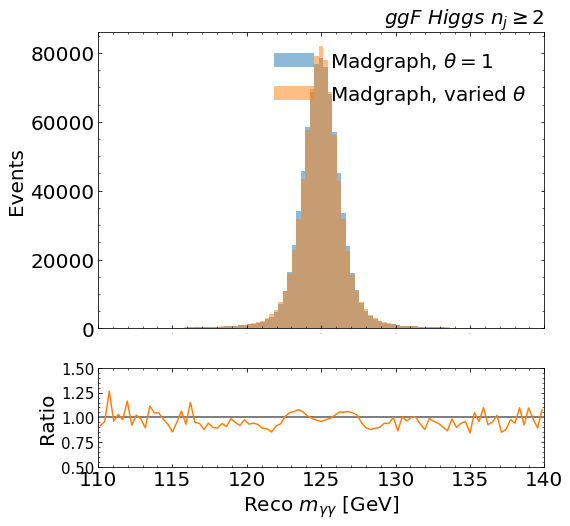

<Figure size 432x288 with 0 Axes>

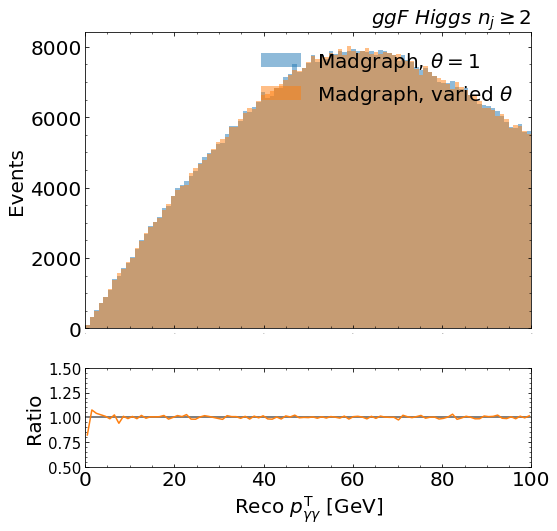

<Figure size 432x288 with 0 Axes>

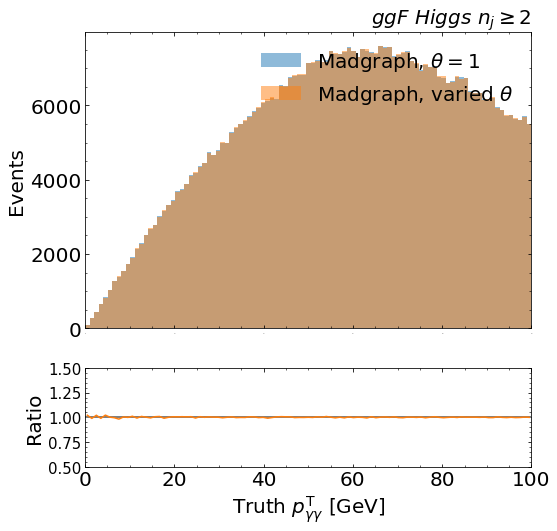

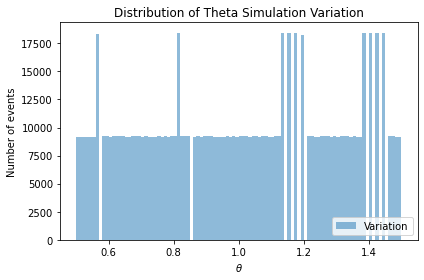

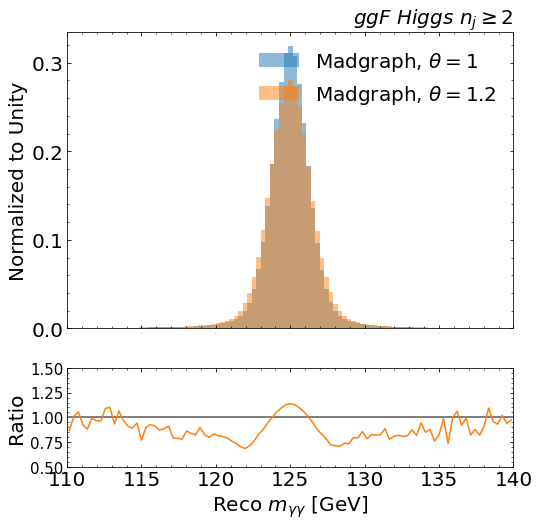

<Figure size 432x288 with 0 Axes>

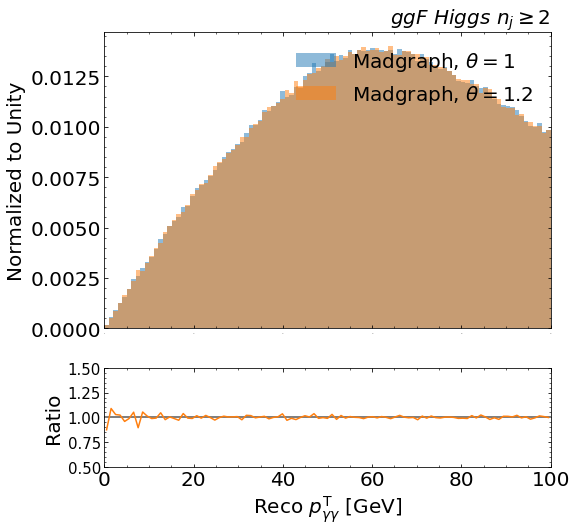

<Figure size 432x288 with 0 Axes>

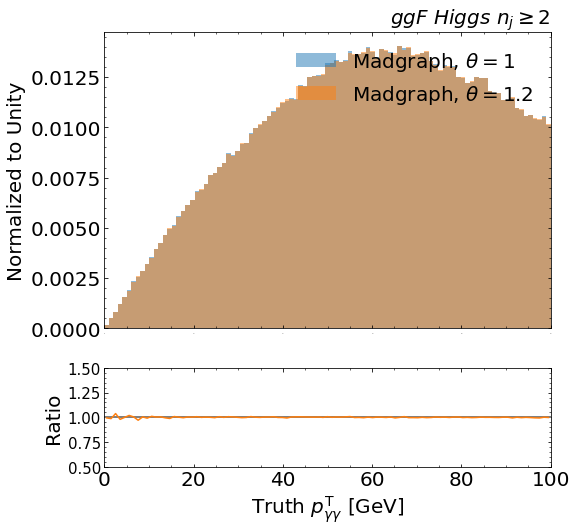

<Figure size 432x288 with 0 Axes>

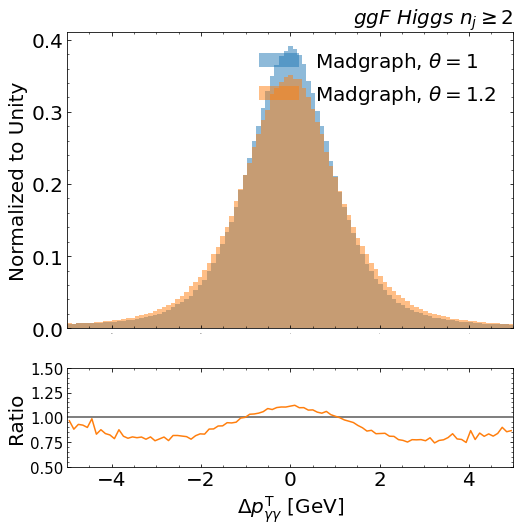

<Figure size 432x288 with 0 Axes>

In [11]:
madgraph_0 = np.load("processed_madgraph_2j_1.0_1000000.npz")
madgraph_1 = np.load("processed_madgraph_2j_1.2_1000000.npz")
madgraph_syst = np.load("processed_madgraph_2j_syst_1000000.npz")

print(list(madgraph_0.keys()))

cpwr = comparison_plots_with_ratio(110, 140, 100, xlabel=r'Reco $m_{\gamma\gamma}$ [GeV]', density=False, ratio_label="Ratio", legend_corner="upper right", header=r"ggF Higgs $n_j \geq 2$")#, save_name=f"Compare_R_forW1network_{today}")
cpwr.add_data(madgraph_0["R_myy"], label=r"Madgraph, $\theta = 1$", alpha=0.5, color='tab:blue', target=True)
cpwr.add_data(madgraph_syst["R_myy"], label=r"Madgraph, varied $\theta$", alpha=0.5, color='tab:orange')
cpwr.show()

cpwr = comparison_plots_with_ratio(0, 100, 100, xlabel=r'Reco $p^\mathrm{T}_{\gamma\gamma}$ [GeV]', density=False, ratio_label="Ratio", legend_corner="upper right", header="ggF Higgs $n_j \geq 2$")#, save_name=f"Compare_R_forW1network_{today}")
cpwr.add_data(madgraph_0["R_Ptyy"], label=r"Madgraph, $\theta = 1$", alpha=0.5, color='tab:blue', target=True)
cpwr.add_data(madgraph_syst["R_Ptyy"], label=r"Madgraph, varied $\theta$", alpha=0.5, color='tab:orange')
cpwr.show()

cpwr = comparison_plots_with_ratio(0, 100, 100, xlabel=r'Truth $p^\mathrm{T}_{\gamma\gamma}$ [GeV]', density=False, ratio_label="Ratio", legend_corner="upper right", header="ggF Higgs $n_j \geq 2$")#, save_name=f"Compare_R_forW1network_{today}")
cpwr.add_data(madgraph_0["T_Ptyy"], label=r"Madgraph, $\theta = 1$", alpha=0.5, color='tab:blue', target=True)
cpwr.add_data(madgraph_syst["T_Ptyy"], label=r"Madgraph, varied $\theta$", alpha=0.5, color='tab:orange')
cpwr.show()

plt.hist(madgraph_syst["Theta"], range=(0.5, 1.5), density=False, bins=100, label="Variation", alpha=0.5)
plt.xlabel(r'$\theta$')
plt.ylabel('Number of events')
plt.title(r'Distribution of Theta Simulation Variation')
plt.legend(loc='lower right')#, framealpha=0)
plt.tight_layout()
plt.show()

cpwr = comparison_plots_with_ratio(110, 140, 100, xlabel=r'Reco $m_{\gamma\gamma}$ [GeV]', density=True, ratio_label="Ratio", legend_corner="upper right", header="ggF Higgs $n_j \geq 2$")#, save_name=f"Compare_R_forW1network_{today}")
cpwr.add_data(madgraph_0["R_myy"], label=r"Madgraph, $\theta = 1$", alpha=0.5, color='tab:blue', target=True)
cpwr.add_data(madgraph_1["R_myy"], label=r"Madgraph, $\theta = 1.2$", alpha=0.5, color='tab:orange')
cpwr.show()

cpwr = comparison_plots_with_ratio(0, 100, 100, xlabel=r'Reco $p^\mathrm{T}_{\gamma\gamma}$ [GeV]', density=True, ratio_label="Ratio", legend_corner="upper right", header="ggF Higgs $n_j \geq 2$")#, save_name=f"Compare_R_forW1network_{today}")
cpwr.add_data(madgraph_0["R_Ptyy"], label=r"Madgraph, $\theta = 1$", alpha=0.5, color='tab:blue', target=True)
cpwr.add_data(madgraph_1["R_Ptyy"], label=r"Madgraph, $\theta = 1.2$", alpha=0.5, color='tab:orange')
cpwr.show()

cpwr = comparison_plots_with_ratio(0, 100, 100, xlabel=r'Truth $p^\mathrm{T}_{\gamma\gamma}$ [GeV]', density=True, ratio_label="Ratio", legend_corner="upper right", header="ggF Higgs $n_j \geq 2$")#, save_name=f"Compare_R_forW1network_{today}")
cpwr.add_data(madgraph_0["T_Ptyy"], label=r"Madgraph, $\theta = 1$", alpha=0.5, color='tab:blue', target=True)
cpwr.add_data(madgraph_1["T_Ptyy"], label=r"Madgraph, $\theta = 1.2$", alpha=0.5, color='tab:orange')
cpwr.show()

cpwr = comparison_plots_with_ratio(-5, 5, 100, xlabel=r'$\Delta p^\mathrm{T}_{\gamma\gamma}$ [GeV]', density=True, ratio_label="Ratio", legend_corner="upper right", header="ggF Higgs $n_j \geq 2$")#, save_name=f"Compare_R_forW1network_{today}")
cpwr.add_data(madgraph_0["R_Ptyy"]-madgraph_0["T_Ptyy"], label=r"Madgraph, $\theta = 1$", alpha=0.5, color='tab:blue', target=True)
cpwr.add_data(madgraph_1["R_Ptyy"]-madgraph_1["T_Ptyy"], label=r"Madgraph, $\theta = 1.2$", alpha=0.5, color='tab:orange')
cpwr.show()

In [12]:
# Convert data into W1 dataset, data loaders and create loss function

T_sim_0 = madgraph_0["T_Ptyy"][:920045].reshape(-1, 1)
T_sim_1 = madgraph_syst["T_Ptyy"].reshape(-1, 1)

R_Ptyy_sim_0 = madgraph_0["R_Ptyy"][:920045].reshape(-1, 1)
R_Ptyy_sim_1 = madgraph_syst["R_Ptyy"].reshape(-1, 1)

R_myy_sim_0 = madgraph_0["R_myy"][:920045].reshape(-1, 1)
R_myy_sim_1 = madgraph_syst["R_myy"].reshape(-1, 1)

Delta_theta = 0.5
theta_sim_0 = ((np.array(list(np.linspace(0.5,1.49,100))*10000)-1.0)/Delta_theta).reshape(-1, 1) # discrete
np.random.shuffle(theta_sim_0)
theta_sim_0 = theta_sim_0[:920045]
theta_sim_1 = ((madgraph_syst["Theta"].astype(float)-1.0)/Delta_theta).reshape(-1, 1)
theta_test = (1.2-1.0)/Delta_theta

R_sim_0 = np.concatenate([R_Ptyy_sim_0, R_myy_sim_0], axis=1)
R_sim_1 = np.concatenate([R_Ptyy_sim_1, R_myy_sim_1], axis=1)

print(T_sim_0.shape, T_sim_1.shape, R_sim_0.shape, R_sim_1.shape, theta_sim_0.shape, theta_sim_1.shape)

w1_ds = w1_dataset(T_sim_0, R_sim_0, theta_sim_0, T_sim_1, R_sim_1, theta_sim_1)
std_params = [
    torch.from_numpy(np.concatenate((T_sim_0, T_sim_1)).mean(axis=0)).to(dvc),
    torch.from_numpy(np.concatenate((T_sim_0, T_sim_1)).std(axis=0)).to(dvc),
    torch.from_numpy(np.concatenate((R_sim_0, R_sim_1)).mean(axis=0)).to(dvc),
    torch.from_numpy(np.concatenate((R_sim_0, R_sim_1)).std(axis=0)).to(dvc)
]
print(std_params)
# split samples to 50% train and 50% test sets
w1_ds_train, w1_ds_test = random_split(w1_ds, [len(w1_ds)//2, len(w1_ds)-len(w1_ds)//2])
w1_dataloader_train = DataLoader(w1_ds_train, batch_size=100000, shuffle=True, num_workers=12)
w1_dataloader_test = DataLoader(w1_ds_test, batch_size=100000, shuffle=False, num_workers=12)

loss_fn = nn.BCELoss()
loss_fn_RT = nn.BCELoss()
loss_fn_T = nn.BCELoss()

(920045, 1) (920045, 1) (920045, 2) (920045, 2) (920045, 1) (920045, 1)
[tensor([108.9107], device='cuda:0', dtype=torch.float64), tensor([87.8341], device='cuda:0', dtype=torch.float64), tensor([102.8705, 131.7401], device='cuda:0', dtype=torch.float64), tensor([81.8296, 73.0375], device='cuda:0', dtype=torch.float64)]


In [9]:
# Create W1 model and training it!

### PLEASE ENTER A NEW MODEL NAME FOR W1 ###
today = str(datetime.date.today())
w1_model_name = f'STXS_deltaTheta0.5_{today}'
print(f"w1_mode_name: {w1_model_name}")

w1RT_model_network = w1RT_network(sigmoid=True, std_params=std_params, n_inputs=4).double().to(dvc)
optimizerRT = optim.Adam(w1RT_model_network.parameters(), lr=0.001)
w1RT_tr = w1_trainer(w1_dataloader_train, w1_dataloader_test, w1RT_model_network, loss_fn_RT, optimizerRT, patience=20)

w1T_model_network = w1T_network(sigmoid=True, std_params=std_params, n_inputs=2).double().to(dvc)
optimizerT = optim.Adam(w1T_model_network.parameters(), lr=0.001)
w1T_tr = w1_trainer(w1_dataloader_train, w1_dataloader_test, w1T_model_network, loss_fn_T, optimizerT)

w1RT_tr.fit()
torch.save(w1RT_model_network, f'model/w1/W1RT_{w1_model_name}.pth')

w1T_tr.fit()
torch.save(w1T_model_network, f'model/w1/W1T_{w1_model_name}.pth')

w1_mode_name: STXS_deltaTheta0.5_2022-12-15
===================== Model W1 =====================
w1RT_network(
  (linear_relu_stack): Sequential(
    (linear_0): Linear(in_features=4, out_features=50, bias=True)
    (relu_0): ReLU()
    (batchNorm_0): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (linear_1): Linear(in_features=50, out_features=50, bias=True)
    (relu_1): ReLU()
    (batchNorm_1): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dropout_1): Dropout(p=0.1, inplace=False)
    (linear_2): Linear(in_features=50, out_features=50, bias=True)
    (relu_2): ReLU()
    (batchNorm_2): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (linear_3): Linear(in_features=50, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)
===================== Model W1 =====================
w1T_network(
  (linear_relu_stack): Sequential(
    (linear_0): Linear(in_features=2, out_feature

[Epoch  71] [Train_loss: 0.690545 Train_auc: 0.537446] [Val_loss: 0.690773 Val_auc: 0.534885]
[Epoch  72] [Train_loss: 0.690039 Train_auc: 0.541860] [Val_loss: 0.690365 Val_auc: 0.538635]
[Epoch  73] [Train_loss: 0.690424 Train_auc: 0.537475] [Val_loss: 0.690619 Val_auc: 0.535492]
[Epoch  74] [Train_loss: 0.690133 Train_auc: 0.540008] [Val_loss: 0.690316 Val_auc: 0.537973]
[Epoch  75] [Train_loss: 0.689812 Train_auc: 0.542420] [Val_loss: 0.690036 Val_auc: 0.540232]
[Epoch  76] [Train_loss: 0.689949 Train_auc: 0.542160] [Val_loss: 0.690180 Val_auc: 0.540147]
[Epoch  77] [Train_loss: 0.690431 Train_auc: 0.537789] [Val_loss: 0.690548 Val_auc: 0.536441]
[Epoch  78] [Train_loss: 0.689465 Train_auc: 0.544784] [Val_loss: 0.689692 Val_auc: 0.542416]
[Epoch  79] [Train_loss: 0.689138 Train_auc: 0.545208] [Val_loss: 0.689462 Val_auc: 0.542720]
[Epoch  80] [Train_loss: 0.688996 Train_auc: 0.546216] [Val_loss: 0.689279 Val_auc: 0.544005]
[Epoch  81] [Train_loss: 0.688462 Train_auc: 0.550457] [Val_

[Epoch 245] [Train_loss: 0.685707 Train_auc: 0.561497] [Val_loss: 0.686427 Val_auc: 0.557512]
[Epoch 246] [Train_loss: 0.685782 Train_auc: 0.561324] [Val_loss: 0.686445 Val_auc: 0.557382]
[Epoch 247] [Train_loss: 0.685544 Train_auc: 0.562254] [Val_loss: 0.686323 Val_auc: 0.558064]
[Epoch 248] [Train_loss: 0.685645 Train_auc: 0.562072] [Val_loss: 0.686513 Val_auc: 0.557492]
[Epoch 249] [Train_loss: 0.686040 Train_auc: 0.560744] [Val_loss: 0.686793 Val_auc: 0.556316]
[Epoch 250] [Train_loss: 0.685907 Train_auc: 0.560916] [Val_loss: 0.686771 Val_auc: 0.556461]
[Epoch 251] [Train_loss: 0.686008 Train_auc: 0.560598] [Val_loss: 0.686718 Val_auc: 0.556283]
[Epoch 252] [Train_loss: 0.685676 Train_auc: 0.562127] [Val_loss: 0.686415 Val_auc: 0.557964]
[Epoch 253] [Train_loss: 0.685904 Train_auc: 0.560904] [Val_loss: 0.686658 Val_auc: 0.556813]
[Epoch 254] [Train_loss: 0.685521 Train_auc: 0.562572] [Val_loss: 0.686283 Val_auc: 0.558005]
[Epoch 255] [Train_loss: 0.685718 Train_auc: 0.561871] [Val_

(919849, 1) (919849, 1) (919849, 2) (919849, 2)


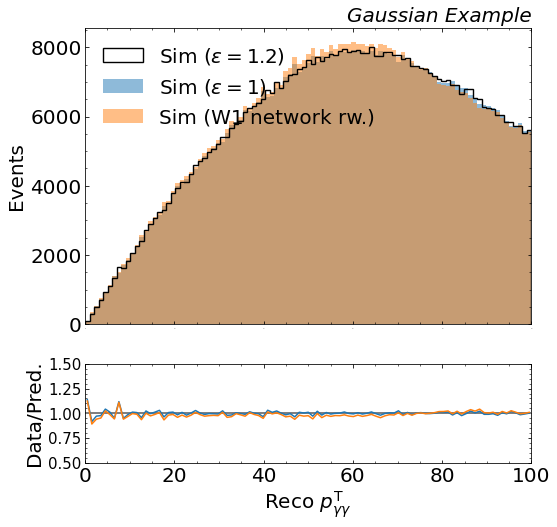

<Figure size 432x288 with 0 Axes>

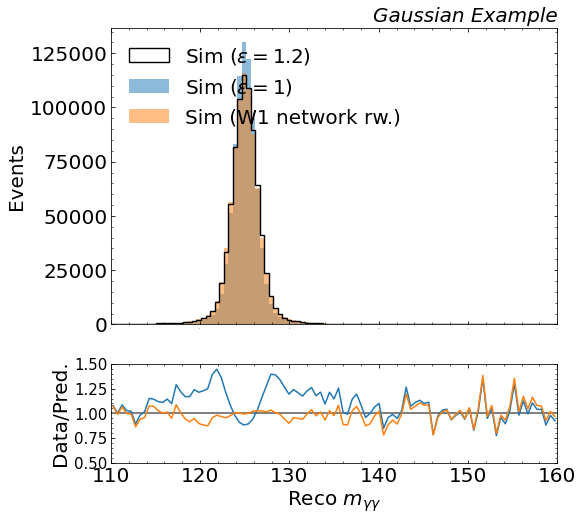

<Figure size 432x288 with 0 Axes>

In [10]:
# Test the trained W1 model

w1_model_name = f'STXS_deltaTheta0.5_2022-12-15'

w1RT_model_name = f'model/w1/W1RT_{w1_model_name}.pth'
w1T_model_name = f'model/w1/W1T_{w1_model_name}.pth'
w1RT_model_network = torch.load(w1RT_model_name).to(dvc)
w1T_model_network = torch.load(w1T_model_name).to(dvc)

T_test_0 = madgraph_0["T_Ptyy"][:919849].reshape(-1, 1)
T_test_1 = madgraph_1["T_Ptyy"].reshape(-1, 1)

R_Ptyy_test_0 = madgraph_0["R_Ptyy"][:919849].reshape(-1, 1)
R_Ptyy_test_1 = madgraph_1["R_Ptyy"].reshape(-1, 1)

R_myy_test_0 = madgraph_0["R_myy"][:919849].reshape(-1, 1)
R_myy_test_1 = madgraph_1["R_myy"].reshape(-1, 1)

R_test_0 = np.concatenate([R_Ptyy_test_0, R_myy_test_0], axis=1)
R_test_1 = np.concatenate([R_Ptyy_test_1, R_myy_test_1], axis=1)

print(T_test_0.shape, T_test_1.shape, R_test_0.shape, R_test_1.shape)

today = str(datetime.date.today())

w1_test_ds = w0_dataset(T_test_0, R_test_0)
w1_test_dataloader = DataLoader(w1_test_ds, batch_size=100000, shuffle=False, num_workers=12)

Ts_0, Rs_0, W1s_0 = test_w1(w1_test_dataloader, w1RT_model_network, w1T_model_network, theta_test)
Ts_0, Rs_0, W1s_0 = Ts_0.cpu().numpy(), Rs_0.cpu().numpy(), W1s_0.cpu().numpy()

cpwr = comparison_plots_with_ratio(0, 100, 100, xlabel=r"Reco $p^\mathrm{T}_{\gamma\gamma}$", density=False, save_name=f"Compare_STXS_ptyy_forW1network_{today}")
cpwr.add_data(R_Ptyy_test_1, label=r"Sim ($\epsilon=1.2$)", target=True, color='black', histtype="step", ls="-", lw=1.4)
cpwr.add_data(Rs_0[:,0], label=r"Sim ($\epsilon=1$)", alpha=0.5, color='tab:blue')
cpwr.add_data(Rs_0[:,0], weights=W1s_0[:,0], label="Sim (W1 network rw.)", alpha=0.5, color='tab:orange')
cpwr.show()

cpwr = comparison_plots_with_ratio(110, 160, 100, xlabel=r"Reco $m_{\gamma\gamma}$", density=False, save_name=f"Compare_STXS_myy_forW1network_{today}")
cpwr.add_data(R_myy_test_1, label=r"Sim ($\epsilon=1.2$)", target=True, color='black', histtype="step", ls="-", lw=1.4)
cpwr.add_data(Rs_0[:,1], label=r"Sim ($\epsilon=1$)", alpha=0.5, color='tab:blue')
cpwr.add_data(Rs_0[:,1], weights=W1s_0[:,0], label="Sim (W1 network rw.)", alpha=0.5, color='tab:orange')
cpwr.show()

['T_Pt_1', 'T_Pt_2', 'R_Pt_1', 'R_Pt_2', 'T_Ptyy', 'R_Ptyy', 'R_myy']


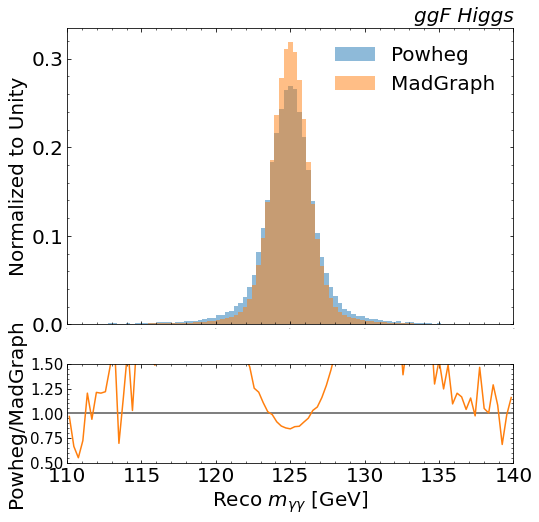

<Figure size 432x288 with 0 Axes>

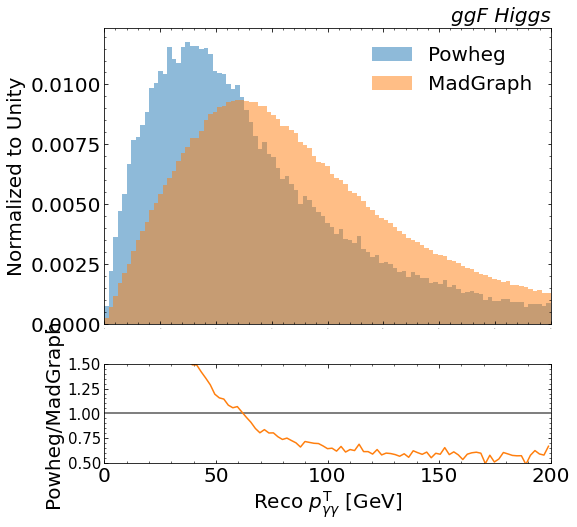

<Figure size 432x288 with 0 Axes>

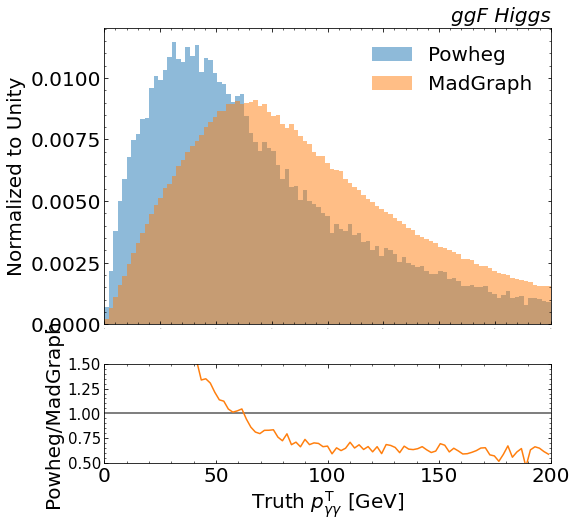

<Figure size 432x288 with 0 Axes>

In [7]:
powheg = np.load("data/processed_powheg_2j_1.2_200000.npz")
madgraph = np.load("data/processed_madgraph_2j_1.0_1000000.npz")

print(list(powheg.keys()))

# cpwr = comparison_plots_with_ratio(110, 140, 100, xlabel=r'Reco $m_{\gamma\gamma}$ [GeV]', density=True, ratio_label="Ratio", legend_corner="upper right", header=r"Madgraph ggF Higgs $n_j \geq 2$")#, save_name=f"Compare_R_forW1network_{today}")
# cpwr.add_data(madgraph["R_myy"][(madgraph["R_Pt_1"].astype(float)<=70) & (madgraph["R_Pt_2"].astype(float)<=60)], label=r"$p^\mathrm{T}_{\gamma_1} < 70$ GeV and $p^\mathrm{T}_{\gamma_2} < 60$ GeV", alpha=0.5, color='tab:blue', target=True)
# cpwr.add_data(madgraph["R_myy"][(madgraph["R_Pt_1"].astype(float)>70) & (madgraph["R_Pt_2"].astype(float)>60)], label=r"$p^\mathrm{T}_{\gamma_1} > 70$ GeV and $p^\mathrm{T}_{\gamma_2} > 60$ GeV", alpha=0.5, color='tab:orange')
# cpwr.show()

# cpwr = comparison_plots_with_ratio(0, 100, 100, xlabel=r'Reco $p^\mathrm{T}_{\gamma_1}$ [GeV]', density=True, ratio_label="Powheg/MadGraph", legend_corner="upper right", header=r"ggF Higgs $n_j \geq 2$")#, save_name=f"Compare_R_forW1network_{today}")
# cpwr.add_data(powheg["R_Pt_1"].astype(float), label=r"Powheg", alpha=0.5, color='tab:blue', target=True)
# cpwr.add_data(madgraph["R_Pt_1"].astype(float), label=r"Madgraph", alpha=0.5, color='tab:orange')
# cpwr.show()

# cpwr = comparison_plots_with_ratio(0, 100, 100, xlabel=r'Reco $p^\mathrm{T}_{\gamma_2}$ [GeV]', density=True, ratio_label="Powheg/MadGraph", legend_corner="upper right", header=r"ggF Higgs $n_j \geq 2$")#, save_name=f"Compare_R_forW1network_{today}")
# cpwr.add_data(powheg["R_Pt_2"].astype(float), label=r"Powheg", alpha=0.5, color='tab:blue', target=True)
# cpwr.add_data(madgraph["R_Pt_2"].astype(float), label=r"Madgraph", alpha=0.5, color='tab:orange')
# cpwr.show()

cpwr = comparison_plots_with_ratio(110, 140, 100, xlabel=r'Reco $m_{\gamma\gamma}$ [GeV]', density=True, ratio_label="Powheg/MadGraph", legend_corner="upper right", header="ggF Higgs")#, save_name=f"Compare_R_forW1network_{today}")
cpwr.add_data(powheg["R_myy"], label="Powheg", alpha=0.5, color='tab:blue', target=True)
cpwr.add_data(madgraph["R_myy"], label="MadGraph", alpha=0.5, color='tab:orange')
cpwr.show()

cpwr = comparison_plots_with_ratio(0, 200, 100, xlabel=r'Reco $p^\mathrm{T}_{\gamma\gamma}$ [GeV]', density=True, ratio_label="Powheg/MadGraph", legend_corner="upper right", header="ggF Higgs")#, save_name=f"Compare_R_forW1network_{today}")
cpwr.add_data(powheg["R_Ptyy"], label="Powheg", alpha=0.5, color='tab:blue', target=True)
cpwr.add_data(madgraph["R_Ptyy"], label="MadGraph", alpha=0.5, color='tab:orange')
cpwr.show()

cpwr = comparison_plots_with_ratio(0, 200, 100, xlabel=r'Truth $p^\mathrm{T}_{\gamma\gamma}$ [GeV]', density=True, ratio_label="Powheg/MadGraph", legend_corner="upper right", header="ggF Higgs")#, save_name=f"Compare_R_forW1network_{today}")
cpwr.add_data(powheg["T_Ptyy"], label="Powheg", alpha=0.5, color='tab:blue', target=True)
cpwr.add_data(madgraph["T_Ptyy"], label="MadGraph", alpha=0.5, color='tab:orange')
cpwr.show()

In [9]:
# Load W1 model and convert data into W0 datasets and data loaders

T_sim = madgraph["T_Ptyy"][:92328].reshape(-1, 1)
T_data = powheg["T_Ptyy"].reshape(-1, 1)

R_Ptyy_sim = madgraph["R_Ptyy"][:92328].reshape(-1, 1)
R_Ptyy_data = powheg["R_Ptyy"].reshape(-1, 1)

R_myy_sim = madgraph["R_myy"][:92328].reshape(-1, 1)
R_myy_data = powheg["R_myy"].reshape(-1, 1)

R_sim = np.concatenate([R_Ptyy_sim, R_myy_sim], axis=1)
R_data = np.concatenate([R_Ptyy_data, R_myy_data], axis=1)

print(T_sim.shape, T_data.shape, R_sim.shape, R_data.shape)

w0_ds = w0_dataset(T_sim, R_sim)
# std_params = [
#     T_sim.mean(),
#     T_sim.std(),
#     R_Ptyy_sim.mean(),
#     R_Ptyy_sim.std()
# ]
std_params = [
    T_sim.mean(),
    T_sim.std(),
    torch.from_numpy(R_sim.mean(axis=0)).to(dvc),
    torch.from_numpy(R_sim.std(axis=0)).to(dvc)
]
print(std_params)
# split samples to 50% train and 50% test sets (can be adjusted)
w0_ds_train, w0_ds_test = random_split(w0_ds, [len(w0_ds)//2, len(w0_ds)-len(w0_ds)//2])#, generator=torch.Generator().manual_seed(42))
w0_dataloader_train = DataLoader(w0_ds_train, batch_size=len(w0_ds_train), shuffle=True, num_workers=12)
w0_dataloader_test = DataLoader(w0_ds_test, batch_size=len(w0_ds_test), shuffle=False, num_workers=12)

w1_model_name = "STXS_deltaTheta0.5_2022-12-15"
w1RT_model_name = f'model/w1/W1RT_{w1_model_name}.pth'
w1T_model_name = f'model/w1/W1T_{w1_model_name}.pth'
w1RT_model_network = torch.load(w1RT_model_name).to(dvc)
w1T_model_network = torch.load(w1T_model_name).to(dvc)
# w1_model_network = w1_dummy().to(dvc)

loss_fn = NLLLoss_2D(R_data, np.linspace(0,200,201), np.linspace(110,140,31), device=dvc)
# loss_fn = NLLLoss(R_data, np.linspace(0,100,101), normalize=False, device=dvc)

(92328, 1) (92328, 1) (92328, 2) (92328, 2)
[108.78174383271597, 87.19179055675701, tensor([102.8734, 131.7648], device='cuda:0', dtype=torch.float64), tensor([81.1856, 73.4087], device='cuda:0', dtype=torch.float64)]


In [9]:
# Create W0 model and train it (also theta)!

### PLEASE ENTER A NEW MODEL NAME FOR W0 AND THETA ###
today = str(datetime.date.today())
w0_model_name = f'w0_gaussian2D_mu0.8epsilon1.2_Lr0p001_with_theta_w1_{w1_model_name}_{today}'
theta_model_name = f'theta_gaussian2D_mu0.8epsilon1.2_Lr0p001_with_w0_w1_{w1_model_name}_{today}'
print(w0_mo0del_name)
print(theta_model_name)

w0_model_network = w0_network(sigmoid=False, std_params=std_params).double().to(dvc)
theta_model = theta_module(0.).to(dvc)

ml = nn.ModuleList()
ml.append(w0_model_network)
ml.append(theta_model)

optimizer = optim.Adam(ml.parameters(), lr=0.0005)
# optimizer_1 = optim.Adam(theta_model.parameters(), lr=0.001)

w0_tr = w0_trainer(w0_dataloader_train, w0_dataloader_test, w0_model_network, w1RT_model_network, w1T_model_network, theta_model, loss_fn, optimizer)
w0_tr.fit()

torch.save(w0_model_network, f'model/w0/{w0_model_name}.pth')
torch.save(theta_model, f'model/theta/{theta_model_name}.pth')

w0_gaussian2D_mu0.8epsilon1.2_Lr0p001_with_theta_w1_STXS_deltaTheta0.5_2022-12-15_2022-12-16
theta_gaussian2D_mu0.8epsilon1.2_Lr0p001_with_w0_w1_STXS_deltaTheta0.5_2022-12-15_2022-12-16
===================== Model W0 =====================
w0_network(
  (linear_relu_stack): Sequential(
    (linear_0): Linear(in_features=1, out_features=50, bias=True)
    (relu_0): ReLU()
    (linear_1): Linear(in_features=50, out_features=50, bias=True)
    (relu_1): ReLU()
    (linear_2): Linear(in_features=50, out_features=50, bias=True)
    (relu_2): ReLU()
    (linear_3): Linear(in_features=50, out_features=1, bias=True)
  )
)
===================== Model W1RT =====================
w1RT_network(
  (linear_relu_stack): Sequential(
    (linear_0): Linear(in_features=4, out_features=50, bias=True)
    (relu_0): ReLU()
    (batchNorm_0): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (linear_1): Linear(in_features=50, out_features=50, bias=True)
    (relu_1): ReLU()
 

[Epoch 145] [Train_loss: -248511.755282] [Val_loss: -248132.264988] [Theta: 0.056100886315107346]
[Epoch 146] [Train_loss: -248516.411313] [Val_loss: -248136.857298] [Theta: 0.056464534252882004]
[Epoch 147] [Train_loss: -248520.791479] [Val_loss: -248141.175990] [Theta: 0.05682981386780739]
[Epoch 148] [Train_loss: -248524.904720] [Val_loss: -248145.239181] [Theta: 0.057196490466594696]
[Epoch 149] [Train_loss: -248528.764028] [Val_loss: -248149.056982] [Theta: 0.05756437033414841]
[Epoch 150] [Train_loss: -248532.380442] [Val_loss: -248152.640981] [Theta: 0.05793319642543793]
[Epoch 151] [Train_loss: -248535.770669] [Val_loss: -248156.004034] [Theta: 0.058302730321884155]
[Epoch 152] [Train_loss: -248538.950360] [Val_loss: -248159.162522] [Theta: 0.05867261067032814]
[Epoch 153] [Train_loss: -248541.931979] [Val_loss: -248162.134874] [Theta: 0.059043038636446]
[Epoch 154] [Train_loss: -248544.727338] [Val_loss: -248164.932127] [Theta: 0.059414006769657135]
[Epoch 155] [Train_loss: -2

[Epoch 313] [Train_loss: -248705.145587] [Val_loss: -248329.256384] [Theta: 0.12113681435585022]
[Epoch 314] [Train_loss: -248705.874095] [Val_loss: -248330.089314] [Theta: 0.12150952219963074]
[Epoch 315] [Train_loss: -248706.595943] [Val_loss: -248330.923014] [Theta: 0.1218818873167038]
[Epoch 316] [Train_loss: -248707.317864] [Val_loss: -248331.756579] [Theta: 0.12225363403558731]
[Epoch 317] [Train_loss: -248708.041677] [Val_loss: -248332.593638] [Theta: 0.12262506783008575]
[Epoch 318] [Train_loss: -248708.765673] [Val_loss: -248333.437130] [Theta: 0.12299634516239166]
[Epoch 319] [Train_loss: -248709.490251] [Val_loss: -248334.282553] [Theta: 0.12336749583482742]
[Epoch 320] [Train_loss: -248710.215778] [Val_loss: -248335.123001] [Theta: 0.12373863905668259]
[Epoch 321] [Train_loss: -248710.941081] [Val_loss: -248335.960477] [Theta: 0.12410970777273178]
[Epoch 322] [Train_loss: -248711.673010] [Val_loss: -248336.788824] [Theta: 0.12448087334632874]
[Epoch 323] [Train_loss: -24871

[Epoch 482] [Train_loss: -248874.587130] [Val_loss: -248540.081511] [Theta: 0.1950802356004715]
[Epoch 483] [Train_loss: -248876.518107] [Val_loss: -248542.118726] [Theta: 0.19569046795368195]
[Epoch 484] [Train_loss: -248878.441223] [Val_loss: -248544.175705] [Theta: 0.19630326330661774]
[Epoch 485] [Train_loss: -248880.361632] [Val_loss: -248546.242506] [Theta: 0.1969180703163147]
[Epoch 486] [Train_loss: -248882.280870] [Val_loss: -248548.318704] [Theta: 0.19753466546535492]
[Epoch 487] [Train_loss: -248884.205156] [Val_loss: -248550.454890] [Theta: 0.19815246760845184]
[Epoch 488] [Train_loss: -248886.127705] [Val_loss: -248552.588869] [Theta: 0.19877122342586517]
[Epoch 489] [Train_loss: -248888.076567] [Val_loss: -248554.717222] [Theta: 0.19939161837100983]
[Epoch 490] [Train_loss: -248890.029064] [Val_loss: -248556.846312] [Theta: 0.2000134289264679]
[Epoch 491] [Train_loss: -248892.005769] [Val_loss: -248558.984309] [Theta: 0.20063647627830505]
[Epoch 492] [Train_loss: -248894.

[Epoch 651] [Train_loss: -249153.448119] [Val_loss: -248825.981268] [Theta: 0.29079267382621765]
[Epoch 652] [Train_loss: -249154.065911] [Val_loss: -248826.367467] [Theta: 0.2911594808101654]
[Epoch 653] [Train_loss: -249154.675203] [Val_loss: -248826.753351] [Theta: 0.2915225923061371]
[Epoch 654] [Train_loss: -249155.271333] [Val_loss: -248827.134039] [Theta: 0.2918822765350342]
[Epoch 655] [Train_loss: -249155.859631] [Val_loss: -248827.505168] [Theta: 0.2922385036945343]
[Epoch 656] [Train_loss: -249156.439181] [Val_loss: -248827.880175] [Theta: 0.2925916910171509]
[Epoch 657] [Train_loss: -249157.018855] [Val_loss: -248828.252093] [Theta: 0.292941689491272]
[Epoch 658] [Train_loss: -249157.596894] [Val_loss: -248828.611757] [Theta: 0.29328954219818115]
[Epoch 659] [Train_loss: -249158.178852] [Val_loss: -248828.973409] [Theta: 0.29363560676574707]
[Epoch 660] [Train_loss: -249158.758851] [Val_loss: -248829.339142] [Theta: 0.29398056864738464]
[Epoch 661] [Train_loss: -249159.3397

[Epoch 736] [Train_loss: -249184.622022] [Val_loss: -248846.054920] [Theta: 0.3142145276069641]
[Epoch 737] [Train_loss: -249184.829615] [Val_loss: -248846.196560] [Theta: 0.3144235610961914]
[Epoch 738] [Train_loss: -249185.035974] [Val_loss: -248846.334856] [Theta: 0.3146318793296814]
[Epoch 739] [Train_loss: -249185.241501] [Val_loss: -248846.472655] [Theta: 0.3148396611213684]
[Epoch 740] [Train_loss: -249185.443415] [Val_loss: -248846.604038] [Theta: 0.3150467276573181]
[Epoch 741] [Train_loss: -249185.644642] [Val_loss: -248846.730607] [Theta: 0.3152531087398529]
[Epoch 742] [Train_loss: -249185.842245] [Val_loss: -248846.858900] [Theta: 0.3154587745666504]
[Epoch 743] [Train_loss: -249186.035214] [Val_loss: -248846.992175] [Theta: 0.31566348671913147]
[Epoch 744] [Train_loss: -249186.226737] [Val_loss: -248847.128544] [Theta: 0.31586700677871704]
[Epoch 745] [Train_loss: -249186.422072] [Val_loss: -248847.267491] [Theta: 0.31606999039649963]
[Epoch 746] [Train_loss: -249186.6158

[Epoch 906] [Train_loss: -249201.781228] [Val_loss: -248858.170310] [Theta: 0.33806511759757996]
[Epoch 907] [Train_loss: -249201.805229] [Val_loss: -248858.199507] [Theta: 0.33812808990478516]
[Epoch 908] [Train_loss: -249201.828344] [Val_loss: -248858.229517] [Theta: 0.3381907045841217]
[Epoch 909] [Train_loss: -249201.850868] [Val_loss: -248858.256390] [Theta: 0.3382526636123657]
[Epoch 910] [Train_loss: -249201.873375] [Val_loss: -248858.272658] [Theta: 0.33831387758255005]
[Epoch 911] [Train_loss: -249201.895585] [Val_loss: -248858.285400] [Theta: 0.3383744955062866]
[Epoch 912] [Train_loss: -249201.917520] [Val_loss: -248858.308399] [Theta: 0.338434636592865]
[Epoch 913] [Train_loss: -249201.939265] [Val_loss: -248858.341292] [Theta: 0.33849412202835083]
[Epoch 914] [Train_loss: -249201.960579] [Val_loss: -248858.366565] [Theta: 0.3385530710220337]
[Epoch 915] [Train_loss: -249201.981613] [Val_loss: -248858.379756] [Theta: 0.33861154317855835]
[Epoch 916] [Train_loss: -249202.002

In [15]:
w0_tr.fit(1000)

torch.save(w0_model_network, f'model/w0/{w0_model_name}.pth')
torch.save(theta_model, f'model/theta/{theta_model_name}.pth')

[Epoch 1000] [Train_loss: -249203.556087] [Val_loss: -248859.474894] [Theta: 0.3428771197795868]
[Epoch 1001] [Train_loss: -249203.579952] [Val_loss: -248859.488145] [Theta: 0.34293442964553833]
[Epoch 1002] [Train_loss: -249203.604559] [Val_loss: -248859.503954] [Theta: 0.3429924547672272]
[Epoch 1003] [Train_loss: -249203.629240] [Val_loss: -248859.518035] [Theta: 0.34305110573768616]
[Epoch 1004] [Train_loss: -249203.654850] [Val_loss: -248859.528894] [Theta: 0.34311068058013916]
[Epoch 1005] [Train_loss: -249203.680471] [Val_loss: -248859.533615] [Theta: 0.3431709408760071]
[Epoch 1006] [Train_loss: -249203.707619] [Val_loss: -248859.540751] [Theta: 0.3432319760322571]
[Epoch 1007] [Train_loss: -249203.735344] [Val_loss: -248859.556708] [Theta: 0.3432939350605011]
[Epoch 1008] [Train_loss: -249203.763624] [Val_loss: -248859.575836] [Theta: 0.34335675835609436]
[Epoch 1009] [Train_loss: -249203.792725] [Val_loss: -248859.593323] [Theta: 0.34342044591903687]
[Epoch 1010] [Train_loss:

[Epoch 1168] [Train_loss: -249208.900544] [Val_loss: -248861.637361] [Theta: 0.35485729575157166]
[Epoch 1169] [Train_loss: -249208.938244] [Val_loss: -248861.640378] [Theta: 0.35494378209114075]
[Epoch 1170] [Train_loss: -249208.976548] [Val_loss: -248861.655701] [Theta: 0.3550315499305725]
[Epoch 1171] [Train_loss: -249209.014444] [Val_loss: -248861.673019] [Theta: 0.35512059926986694]
[Epoch 1172] [Train_loss: -249209.053315] [Val_loss: -248861.693800] [Theta: 0.355210542678833]
[Epoch 1173] [Train_loss: -249209.092674] [Val_loss: -248861.712895] [Theta: 0.3553014397621155]
[Epoch 1174] [Train_loss: -249209.132789] [Val_loss: -248861.714496] [Theta: 0.35539349913597107]
[Epoch 1175] [Train_loss: -249209.172842] [Val_loss: -248861.719811] [Theta: 0.3554864823818207]
[Epoch 1176] [Train_loss: -249209.213364] [Val_loss: -248861.728657] [Theta: 0.35558000206947327]
[Epoch 1177] [Train_loss: -249209.254201] [Val_loss: -248861.749232] [Theta: 0.3556744158267975]
[Epoch 1178] [Train_loss: 

Fitted epsilon = 1.182859092950821
[Test_loss: -249281.686659]


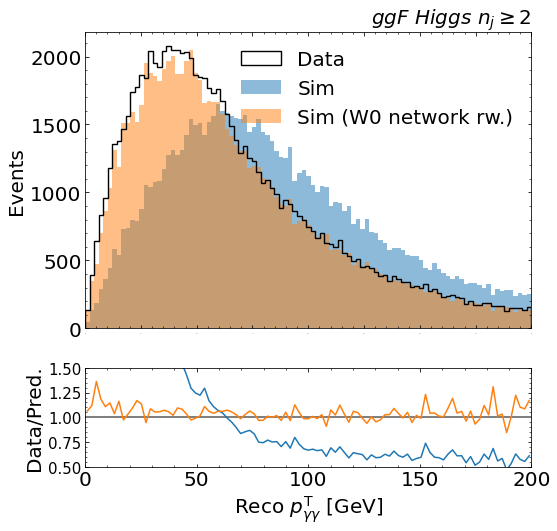

<Figure size 432x288 with 0 Axes>

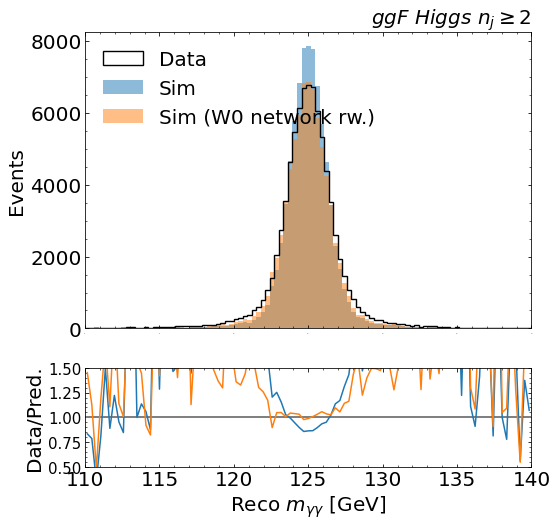

<Figure size 432x288 with 0 Axes>

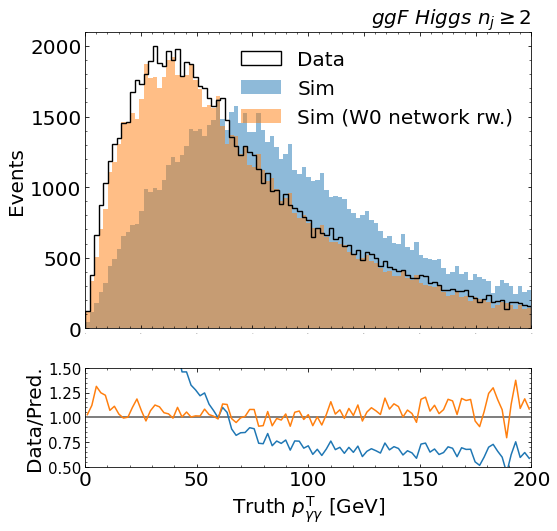

<Figure size 432x288 with 0 Axes>

In [10]:
# Test the trained W0 model and fitted theta value

w0_model_name_0 = f'w0_gaussian2D_mu0.8epsilon1.2_Lr0p001_with_theta_w1_STXS_deltaTheta0.5_2022-12-15_2022-12-16'
w0_model_network_0 = torch.load(f'model/w0/{w0_model_name_0}.pth')

theta_model_name_0 = f'theta_gaussian2D_mu0.8epsilon1.2_Lr0p001_with_w0_w1_STXS_deltaTheta0.5_2022-12-15_2022-12-16'
theta_model_0 = torch.load(f'model/theta/{theta_model_name_0}.pth')

print(f"Fitted epsilon = {theta_model_0().item()*0.5+1}")

today = str(datetime.date.today())

Ts_0, Rs_0, Ws_0, W0s_0, W1s_0 = test_w0(w0_dataloader_test, w0_model_network_0, w1RT_model_network, w1T_model_network, theta_model_0, loss_fn)
Ts_0, Rs_0, Ws_0, W0s_0, W1s_0 = Ts_0.cpu().numpy(), Rs_0.cpu().numpy(), Ws_0.cpu().numpy(), W0s_0.cpu().numpy(), W1s_0.cpu().numpy()

cpwr = comparison_plots_with_ratio(0, 200, 100, xlabel=r"Reco $p^\mathrm{T}_{\gamma\gamma}$ [GeV]", density=False, save_name=f"STXS_Compare_R_mtyy_{today}", legend_corner="upper right", header=r"ggF Higgs $n_j \geq 2$")
cpwr.add_data(R_Ptyy_data, label="Data", target=True, color='black', histtype="step", ls="-", lw=1.4)
cpwr.add_data(Rs_0[:, 0], weights=Rs_0[:, 0]*2/Rs_0[:, 0], label="Sim", alpha=0.5, color='tab:blue')
cpwr.add_data(Rs_0[:, 0], weights=Ws_0, label="Sim (W0 network rw.)", alpha=0.5, color='tab:orange')
cpwr.show()

cpwr = comparison_plots_with_ratio(110, 140, 100, xlabel=r"Reco $m_{\gamma\gamma}$ [GeV]", density=False, save_name=f"STXS_Compare_R_myy_{today}", header=r"ggF Higgs $n_j \geq 2$")
cpwr.add_data(R_myy_data, label="Data", target=True, color='black', histtype="step", ls="-", lw=1.4)
cpwr.add_data(Rs_0[:, 1], weights=Rs_0[:, 1]*2/Rs_0[:, 1], label="Sim", alpha=0.5, color='tab:blue')
cpwr.add_data(Rs_0[:, 1], weights=Ws_0, label="Sim (W0 network rw.)", alpha=0.5, color='tab:orange')
cpwr.show()

cpwr = comparison_plots_with_ratio(0, 200, 100, xlabel=r"Truth $p^\mathrm{T}_{\gamma\gamma}$ [GeV]", density=False, save_name=f"STXS_Compare_T_ptyy_{today}", legend_corner="upper right", header=r"ggF Higgs $n_j \geq 2$")
cpwr.add_data(T_data, label="Data", target=True, color='black', histtype="step", ls="-", lw=1.4)
cpwr.add_data(Ts_0, weights=Ts_0*2/Ts_0, label="Sim", alpha=0.5, color='tab:blue')
cpwr.add_data(Ts_0, weights=W0s_0, label="Sim (W0 network rw.)", alpha=0.5, color='tab:orange')
cpwr.show()

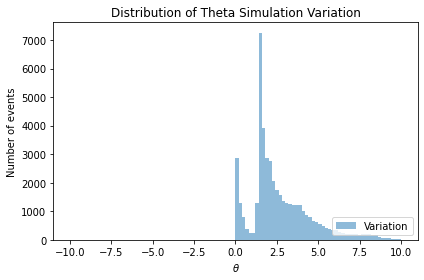

0.7445581935224883

In [21]:
plt.hist(Ws_0, range=(-10, 10), density=False, bins=100, label="Variation", alpha=0.5)
plt.xlabel(r'$\theta$')
plt.ylabel('Number of events')
plt.title(r'Distribution of Theta Simulation Variation')
plt.legend(loc='lower right')#, framealpha=0)
plt.tight_layout()
plt.show()

2/Ws_0.mean()